
# <p style="text-align: center;">Large Weather and Decrees</p>

work on pur decrees then, do yearly drought, then create all missing communes for all messing years, then add latitude longitude

In [1]:
#!pip install cartopy
#!pip install imageio

## Import libraries

In [2]:
import pandas as pd
import numpy as np

import glob
import os

import requests

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import zipfile

import xarray as xr

import folium
from folium.plugins import MarkerCluster

import pandas as pd
from geopy.geocoders import Nominatim

import geopandas as gpd
import cartopy.crs as ccrs

import imageio

from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

from sklearn.preprocessing import RobustScaler

## Set parameters

In [ ]:
decree_filename_base = 'arrete_'
decrees_folder_name = './../../data/raw/decrees'
communes_folder_name = './../../data/raw/opendatasoft'
weather_folder_name = './../../data/raw/weather/era5'
weather_ncfiles_folder_name = './../../data/raw/weather/era5/ncfiles2'
processed_data_folder_name = './../../data/processed'
output_data_folder_name = './../../data/processed/output'
decrees_filename = 'decrees.parquet'
decrees_locations_filename = 'decrees_locations.parquet'
communes_csv_filename = 'correspondance-code-insee-code-postal.csv'
weather_filename = 'weather2.parquet'
weather_shema = 'weather_shema2.csv'
weather_yearly_filename = 'weather2_yearly.parquet'
weather_yearly_shema = 'weather_shema2_yearly.csv'
drought_filename = 'drought.parquet'
drought_shema = 'drought_shema.csv'
drought_yearly_filename = 'drought_yearly.parquet'
drought_yearly_shema = 'drought_yearly_shema.csv'
#weather_zip_file = "193fcd51a8958175843ecbbcaba057c8.zip"

## Load Weather data

| Column    | Description                                      |
|-----------|--------------------------------------------------|
| date      | The date of the observation.                     |
| latitude  | The latitude coordinate of the observation point.|
| longitude | The longitude coordinate of the observation point.|
| number    | A unique identifier for the observation.         |
| expver    | Experiment version number.                       |
| u10       | 10-meter U-component of wind (eastward wind).    |
| v10       | 10-meter V-component of wind (northward wind).   |
| t2m       | 2-meter temperature (air temperature at 2 meters above the surface).|
| sp        | Surface pressure.                                |
| tp        | Total precipitation.                             |
| e         | Evaporation.                                     |
| sro       | Surface runoff.                                  |
| tcrw      | Total column water vapor.                        |
| stl1      | Soil temperature level 1.                        |
| stl2      | Soil temperature level 2.                        |
| slt       | Soil type.                                       |
| swvl1     | Volumetric soil water layer 1.                   |
| swvl2     | Volumetric soil water layer 2.                   |
| cvh       | High vegetation cover.                           |
| cvl       | Low vegetation cover.                            |
| tvh       | High vegetation type.                            |
| tvl       | Low vegetation type.                             |


In [4]:
df_yearly_weather = pd.read_parquet(os.path.join(processed_data_folder_name, weather_yearly_filename))

In [5]:
df_yearly_weather.head()

latitude  longitude  year  t2m_z_sum  t2m_z_mean  tp_z_sum  tp_z_mean  \
0      42.5       -5.0  1940   0.000000         NaN  0.000000        NaN   
1      42.5       -5.0  1941   0.000000    0.000000 -1.414214  -0.117851   
2      42.5       -5.0  1942   2.590982    0.215915  0.948012   0.079001   
3      42.5       -5.0  1943   3.948252    0.329021 -5.062950  -0.421913   
4      42.5       -5.0  1944  -0.020748   -0.001729 -2.657244  -0.221437   

    e_z_sum  e_z_mean  pev_z_sum  ...    stl1_sum  stl1_mean    stl2_sum  \
0  0.000000       NaN   0.000000  ...  131.224976  10.935414  131.221069   
1  1.414214  0.117851  -1.414214  ...  130.369019  10.864085  129.770386   
2 -2.155737 -0.179645  -0.856798  ...  132.005249  11.000438  131.522339   
3 -0.876471 -0.073039  -7.460276  ...  143.968140  11.997345  143.213501   
4  5.106711  0.425559  -5.488278  ...  133.577759  11.131480  133.382690   

   stl2_mean  slt_sum  slt_mean  swvl1_sum  swvl1_mean  swvl2_sum  swvl2_mean  
0  10.935089     36.0       3.0   3.491412    0.290951   3.582633    0.298553  
1  10.814198     36.0       3.0   3.291583    0.274299   3.486492    0.290541  
2  10.960195     36.0       3.0   3.473109    0.289426   3.584625    0.298719  
3  11.934459     36.0       3.0   3.147441    0.262287   3.267897    0.272325  
4  11.115224     36.0       3.0   2.850830    0.237569   2.922482    0.243540  

[5 rows x 39 columns]

In [6]:
df_yearly_weather.columns

Index(['latitude', 'longitude', 'year', 't2m_z_sum', 't2m_z_mean', 'tp_z_sum',
       'tp_z_mean', 'e_z_sum', 'e_z_mean', 'pev_z_sum', 'pev_z_mean',
       'stl1_z_sum', 'stl1_z_mean', 'stl2_z_sum', 'stl2_z_mean', 'slt_z_sum',
       'slt_z_mean', 'swvl1_z_sum', 'swvl1_z_mean', 'swvl2_z_sum',
       'swvl2_z_mean', 't2m_sum', 't2m_mean', 'tp_sum', 'tp_mean', 'e_sum',
       'e_mean', 'pev_sum', 'pev_mean', 'stl1_sum', 'stl1_mean', 'stl2_sum',
       'stl2_mean', 'slt_sum', 'slt_mean', 'swvl1_sum', 'swvl1_mean',
       'swvl2_sum', 'swvl2_mean'],
      dtype='object')

In [7]:
df_yearly_weather.dtypes

latitude        float64
longitude       float64
year              int32
t2m_z_sum       float64
t2m_z_mean      float64
tp_z_sum        float64
tp_z_mean       float64
e_z_sum         float64
e_z_mean        float64
pev_z_sum       float64
pev_z_mean      float64
stl1_z_sum      float64
stl1_z_mean     float64
stl2_z_sum      float64
stl2_z_mean     float64
slt_z_sum       float64
slt_z_mean      float64
swvl1_z_sum     float64
swvl1_z_mean    float64
swvl2_z_sum     float64
swvl2_z_mean    float64
t2m_sum         float32
t2m_mean        float32
tp_sum          float32
tp_mean         float32
e_sum           float32
e_mean          float32
pev_sum         float32
pev_mean        float32
stl1_sum        float32
stl1_mean       float32
stl2_sum        float32
stl2_mean       float32
slt_sum         float32
slt_mean        float32
swvl1_sum       float32
swvl1_mean      float32
swvl2_sum       float32
swvl2_mean      float32
dtype: object

In [8]:
# Load the schema (data types) from the file
schema_yearly = pd.read_csv(os.path.join(processed_data_folder_name, weather_yearly_shema), index_col=0).squeeze("columns")

In [9]:
# Apply the schema to the loaded dataframe
df_yearly_weather = df_yearly_weather.astype(schema_yearly.to_dict())

In [10]:
df_yearly_weather.dtypes

latitude        float64
longitude       float64
year              int32
t2m_z_sum       float64
t2m_z_mean      float64
tp_z_sum        float64
tp_z_mean       float64
e_z_sum         float64
e_z_mean        float64
pev_z_sum       float64
pev_z_mean      float64
stl1_z_sum      float64
stl1_z_mean     float64
stl2_z_sum      float64
stl2_z_mean     float64
slt_z_sum       float64
slt_z_mean      float64
swvl1_z_sum     float64
swvl1_z_mean    float64
swvl2_z_sum     float64
swvl2_z_mean    float64
t2m_sum         float32
t2m_mean        float32
tp_sum          float32
tp_mean         float32
e_sum           float32
e_mean          float32
pev_sum         float32
pev_mean        float32
stl1_sum        float32
stl1_mean       float32
stl2_sum        float32
stl2_mean       float32
slt_sum         float32
slt_mean        float32
swvl1_sum       float32
swvl1_mean      float32
swvl2_sum       float32
swvl2_mean      float32
dtype: object

In [11]:
print(df_yearly_weather.isna().sum())  # Count missing values

latitude           0
longitude          0
year               0
t2m_z_sum          0
t2m_z_mean      1925
tp_z_sum           0
tp_z_mean       1925
e_z_sum            0
e_z_mean        1925
pev_z_sum          0
pev_z_mean      1925
stl1_z_sum         0
stl1_z_mean     1925
stl2_z_sum         0
stl2_z_mean     1925
slt_z_sum          0
slt_z_mean      1925
swvl1_z_sum        0
swvl1_z_mean    1925
swvl2_z_sum        0
swvl2_z_mean    1925
t2m_sum            0
t2m_mean           0
tp_sum             0
tp_mean            0
e_sum              0
e_mean             0
pev_sum            0
pev_mean           0
stl1_sum           0
stl1_mean          0
stl2_sum           0
stl2_mean          0
slt_sum            0
slt_mean           0
swvl1_sum          0
swvl1_mean         0
swvl2_sum          0
swvl2_mean         0
dtype: int64


In [12]:
# Filter the DataFrame to exclude the year 1940
df_yearly_weather[df_yearly_weather['year'] != 1940].isna().sum().sum()




0

In [13]:
df_yearly_weather.drop(df_yearly_weather[df_yearly_weather['year'] == 1940].index, inplace=True)

In [14]:
df_yearly_weather.isna().sum().sum()

0

### Note

>There are no missing values in weather data because they come from monthly ERA5 simulations based on real data. only missing in 1940 du to rolling window for featured parameters.

## Import Decrees

In [15]:


df_decrees = pd.read_parquet(os.path.join(processed_data_folder_name, decrees_filename))

In [16]:
df_decrees.head()

insee           nom_commune debut_evenement fin_evenement date_arrete  \
43661  5063              LA GRAVE      2001-03-19    2001-03-25  2001-11-15   
43662  5128  SAINT ANDRE D EMBRUN      2001-03-29    2001-03-29  2001-11-15   
43663  6031              CANTARON      2000-11-23    2000-11-24  2001-11-15   
43664  6031              CANTARON      2000-11-23    2000-11-24  2001-11-15   
43665  6057            L'ESCARENE      2000-10-30    2000-10-31  2001-11-15   

      date_parution_jo                          nom_peril code_peril  \
43661       2001-12-01               Mouvement de Terrain        MVT   
43662       2001-12-01               Mouvement de Terrain        MVT   
43663       2001-12-01               Mouvement de Terrain        MVT   
43664       2001-12-01  Inondations et/ou Coulées de Boue        ICB   
43665       2001-12-01               Mouvement de Terrain        MVT   

      franchise      code_nor  decision  
43661    Simple  INTE0100649A  Reconnue  
43662    Simple  INTE0100649A  Reconnue  
43663    Simple  INTE0100649A  Reconnue  
43664    Simple  INTE0100649A  Reconnue  
43665    Simple  INTE0100649A  Reconnue

## Data Recording Period 

In [17]:
df_decrees.describe()

debut_evenement                  fin_evenement  \
count                         235462                         235462   
mean   2005-10-13 08:16:52.627090560  2006-01-17 04:56:49.711970304   
min              1985-01-01 00:00:00            1985-05-15 00:00:00   
25%              1999-12-25 00:00:00            1999-12-29 00:00:00   
50%              2002-11-23 00:00:00            2002-12-31 00:00:00   
75%              2016-01-01 00:00:00            2016-03-31 00:00:00   
max              2024-05-24 00:00:00            2024-05-26 00:00:00   

                         date_arrete               date_parution_jo  
count                         235462                         235462  
mean   2006-07-06 06:26:51.775997952  2006-07-18 04:28:52.804444160  
min              1987-05-20 00:00:00            1987-05-24 00:00:00  
25%              1999-12-29 00:00:00            1999-12-30 00:00:00  
50%              2003-10-03 00:00:00            2003-10-19 00:00:00  
75%              2016-09-16 00:00:00            2016-10-20 00:00:00  
max              2024-06-18 00:00:00            2024-07-02 00:00:00

### Note

>Gathered data are from 1982 to 2024.

## Describe Categorical Data

In [18]:
df_decrees.dtypes

insee                       object
nom_commune                 object
debut_evenement     datetime64[ns]
fin_evenement       datetime64[ns]
date_arrete         datetime64[ns]
date_parution_jo    datetime64[ns]
nom_peril                   object
code_peril                  object
franchise                   object
code_nor                    object
decision                    object
dtype: object

In [19]:
df_decrees.select_dtypes(include=['object']).describe()

insee   nom_commune                          nom_peril code_peril  \
count   235462        235462                             235462     235462   
unique   37496         33569                                 22         22   
top      81065  SAINTE MARIE  Inondations et/ou Coulées de Boue        ICB   
freq        55           101                             112288     112288   

       franchise      code_nor  decision  
count     235462        235462    235462  
unique         5           738         3  
top       Simple  INTE9900627A  Reconnue  
freq      189348         58229    130517

## Create year of event column

In [20]:
#df_decrees['start_event_year'] = df_decrees['debut_evenement'].dt.year

In [21]:
df_decrees.head()

insee           nom_commune debut_evenement fin_evenement date_arrete  \
43661  5063              LA GRAVE      2001-03-19    2001-03-25  2001-11-15   
43662  5128  SAINT ANDRE D EMBRUN      2001-03-29    2001-03-29  2001-11-15   
43663  6031              CANTARON      2000-11-23    2000-11-24  2001-11-15   
43664  6031              CANTARON      2000-11-23    2000-11-24  2001-11-15   
43665  6057            L'ESCARENE      2000-10-30    2000-10-31  2001-11-15   

      date_parution_jo                          nom_peril code_peril  \
43661       2001-12-01               Mouvement de Terrain        MVT   
43662       2001-12-01               Mouvement de Terrain        MVT   
43663       2001-12-01               Mouvement de Terrain        MVT   
43664       2001-12-01  Inondations et/ou Coulées de Boue        ICB   
43665       2001-12-01               Mouvement de Terrain        MVT   

      franchise      code_nor  decision  start_event_year  
43661    Simple  INTE0100649A  Reconnue              2001  
43662    Simple  INTE0100649A  Reconnue              2001  
43663    Simple  INTE0100649A  Reconnue              2000  
43664    Simple  INTE0100649A  Reconnue              2000  
43665    Simple  INTE0100649A  Reconnue              2000

### Add the columns latitude and longitude

In [22]:

'''
# Split the 'geo_point_2d' column into 'latitude' and 'longitude'
df_decrees[['latitude', 'longitude']] = df_decrees['geo_point_2d'].str.split(',', expand=True)

# Convert the new columns to float
df_decrees['latitude'] = df_decrees['latitude'].astype(float)
df_decrees['longitude'] = df_decrees['longitude'].astype(float)
'''

"\n# Split the 'geo_point_2d' column into 'latitude' and 'longitude'\ndf_decrees[['latitude', 'longitude']] = df_decrees['geo_point_2d'].str.split(',', expand=True)\n\n# Convert the new columns to float\ndf_decrees['latitude'] = df_decrees['latitude'].astype(float)\ndf_decrees['longitude'] = df_decrees['longitude'].astype(float)\n"

In [23]:
df_decrees.columns

Index(['insee', 'nom_commune', 'debut_evenement', 'fin_evenement',
       'date_arrete', 'date_parution_jo', 'nom_peril', 'code_peril',
       'franchise', 'code_nor', 'decision', 'start_event_year'],
      dtype='object')

### Drought dataframe

In [24]:
df_drought = df_decrees[df_decrees['code_peril'] == 'SEC'].copy()

In [25]:
df_drought.head()

insee      nom_commune debut_evenement fin_evenement date_arrete  \
43673  12018  BALAGUIER D OLT      1990-01-01    1990-09-30  2001-11-15   
43674  12018  BALAGUIER D OLT      1992-03-01    1992-06-30  2001-11-15   
43677  17118         CORIGNAC      1989-05-01    1989-12-31  2001-11-15   
43678  17203         LANDRAIS      1990-01-01    1990-09-30  2001-11-15   
43679  17260          NEUVICQ      1989-05-01    1989-12-31  2001-11-15   

      date_parution_jo   nom_peril code_peril franchise      code_nor  \
43673       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43674       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43677       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43678       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43679       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   

       decision  start_event_year  
43673  Reconnue              1990  
43674  Reconnue              1992  
43677  Reconnue              1989  
43678  Reconnue              1990  
43679  Reconnue              1989

#### Drought duration

In [26]:
# Calculate the length of the event in days for df_drought
df_drought['event_length_days'] = (df_drought['fin_evenement'] - df_drought['debut_evenement']).dt.days

# Display the DataFrame with the new column
print(df_drought[['debut_evenement', 'fin_evenement', 'event_length_days']].head())


      debut_evenement fin_evenement  event_length_days
43673      1990-01-01    1990-09-30                272
43674      1992-03-01    1992-06-30                121
43677      1989-05-01    1989-12-31                244
43678      1990-01-01    1990-09-30                272
43679      1989-05-01    1989-12-31                244


In [27]:
df_drought.event_length_days.describe()

count    73322.000000
mean       297.473978
std        419.362809
min          0.000000
25%         91.000000
50%        182.000000
75%        364.000000
max       4747.000000
Name: event_length_days, dtype: float64

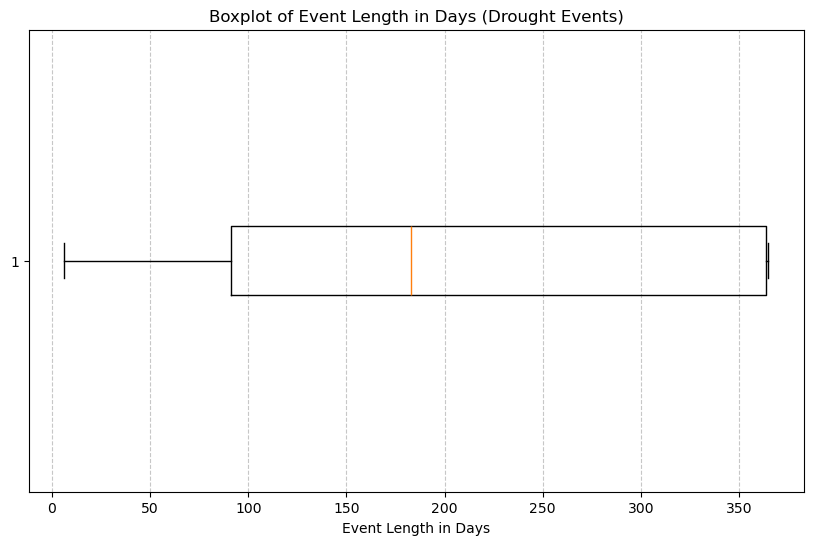

In [28]:
# Function to plot a boxplot for 'event_length_days' with optional filtering by start_year
def plot_drought_event_length(df_drought, start_year=None):
    # Optional filtering by start_year
    if start_year is not None:
        df_drought = df_drought[df_drought['debut_evenement'].dt.year >= start_year]

    # Create a boxplot for the 'event_length_days' column
    plt.figure(figsize=(10, 6))
    plt.boxplot(df_drought['event_length_days'].dropna(), vert=False)
    plt.title('Boxplot of Event Length in Days (Drought Events)')
    plt.xlabel('Event Length in Days')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
plot_drought_event_length(df_drought, start_year=2020)

In [30]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Calculate the minimum and maximum event_length_days across the entire DataFrame
overall_min = df_drought['event_length_days'].min()
overall_max = df_drought['event_length_days'].max()

# Create the interactive slider widget
slider = widgets.IntSlider(
    value=2000,  # Default value
    min=df_drought['debut_evenement'].dt.year.min(),  # Minimum year available in the data
    max=df_drought['debut_evenement'].dt.year.max(),  # Maximum year available in the data
    step=1,
    description='Start Year:',
    continuous_update=False  # Ensures updates happen only when the user stops moving the slider
)

# Function to plot the interactive boxplot using plotly express
def plot_interactive_drought_event_length(start_year=2000):
    # Clear the entire output before displaying new plot
    clear_output(wait=True)

    # Display the slider again
    display(slider)

    # Filter the dataframe based on the start_year
    filtered_df = df_drought[df_drought['debut_evenement'].dt.year >= start_year]

    # If filtered_df is empty, do not create the boxplot to avoid plotting an empty figure
    if filtered_df.empty:
        print("No data available for the selected start year.")
    else:
        # Create the boxplot with plotly express, setting the x-axis range
        fig = px.box(
            filtered_df,
            x='event_length_days',
            title=f'Boxplot of Event Length in Days (Drought Events from {start_year} onward)',
            labels={'event_length_days': 'Event Length in Days'}
        )
        
        # Set the x-axis range for consistency
        fig.update_layout(xaxis=dict(range=[overall_min, overall_max]))
        
        # Display the new figure
        fig.show()

# Link the slider to the plotting function
slider.observe(lambda change: plot_interactive_drought_event_length(change.new), names='value')

# Display the slider and initialize the output
display(slider)
plot_interactive_drought_event_length(slider.value)


IntSlider(value=2000, continuous_update=False, description='Start Year:', max=2023, min=1988)

In [32]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a quantile slider widget
quantile_slider = widgets.FloatSlider(
    value=0.5,  # Default value
    min=0.0,    # Minimum quantile
    max=1.0,    # Maximum quantile
    step=0.05,  # Step size for the quantile
    description='Quantile:',
    continuous_update=False  # Ensures updates happen only when the user stops moving the slider
)

# Function to plot the interactive max quantile value across years using plotly express
def plot_max_quantile(df_drought, quantile=0.5):
    # Clear the entire output before displaying new plot
    clear_output(wait=True)

    # Display the quantile slider again
    display(quantile_slider)

    # Group by year and calculate the quantile for each year
    df_drought['year'] = df_drought['debut_evenement'].dt.year
    grouped = df_drought.groupby('year')['event_length_days'].quantile(quantile)

    # Create a new dataframe with the year and the calculated quantile
    df_quantile = pd.DataFrame({'year': grouped.index, 'quantile_value': grouped.values})

    # Plot the maximum value of the quantile across years
    fig = px.line(
        df_quantile,
        x='year',
        y='quantile_value',
        title=f'{quantile*100:.0f}th Percentile of Event Length in Days Across Years',
        labels={'quantile_value': f'{quantile*100:.0f}th Percentile of Event Length (Days)', 'year': 'Year'}
    )

    # Display the new figure
    fig.show()

# Link the slider to the plotting function
quantile_slider.observe(lambda change: plot_max_quantile(df_drought, change.new), names='value')

# Display the slider and initialize the output
display(quantile_slider)
plot_max_quantile(df_drought, quantile_slider.value)


FloatSlider(value=0.5, continuous_update=False, description='Quantile:', max=1.0, step=0.05)

### Note

> It seems that thare is a change around 2000 in the durations of drought.\
> Another factor to consider is that experts tell us we are heading towards an annual declaration of drought status.\
 Thus, the question is no longer from when to when is the drought, but rather whether this year will be declared a natural drought disaster or not.

In [65]:
import pandas as pd
import plotly.express as px

# Function to plot boxplots of the months of debut_evenement and fin_evenement using Plotly Express
def plot_start_end_month_boxplots(df_drought, filter_reconnue=True):
    # Make a copy of the original DataFrame with a different name to ensure no changes are made to the original
    df_drought_copy = df_drought.copy()

    # Filter the DataFrame if filter_reconnue is True
    if filter_reconnue:
        df_drought_copy = df_drought_copy[df_drought_copy['decision'] == 'Reconnue']

    # Extract months from 'debut_evenement' and 'fin_evenement'
    df_drought_copy['debut_month'] = df_drought_copy['debut_evenement'].dt.month
    df_drought_copy['fin_month'] = df_drought_copy['fin_evenement'].dt.month

    # Melt the DataFrame to bring debut_month and fin_month into a single column for easier comparison
    df_melted = pd.melt(
        df_drought_copy,
        id_vars=['insee', 'nom_commune'],  # Preserving some columns to identify rows
        value_vars=['debut_month', 'fin_month'],
        var_name='Event Type',
        value_name='Month'
    )

    # Replace column names to make them more descriptive in the plot
    df_melted['Event Type'] = df_melted['Event Type'].replace({
        'debut_month': 'Month of Debut Evenement',
        'fin_month': 'Month of Fin Evenement'
    })

    # Plotting with Plotly Express
    fig = px.box(
        df_melted,
        x='Event Type',
        y='Month',
        title='Boxplot of Months of Debut and Fin Evenement',
        labels={'Month': 'Month (1=January, 12=December)'},
        color='Event Type'  # Different colors for debut and fin events
    )

    # Show the plot
    fig.show()

# Example usage:
# Assuming df_drought is already defined and contains 'debut_evenement' and 'fin_evenement' columns as datetime
plot_start_end_month_boxplots(df_drought, filter_reconnue=True)


### Note

> Given that over 75% of drought periods begin before summer, a second predictive model trained on pre-summer data could provide valuable mid-year forecasts on whether the state will approve natural catastrophe measures. This approach enhances early detection and response.

In [67]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to create and display the interactive line plot with sliders
def plot_drought_decisions_interactive(df_drought):
    # Create sliders for vertical lines and yellow highlighted rectangle
    vline_1_slider = widgets.IntSlider(
        value=1999,
        min=df_drought['debut_evenement'].dt.year.min(),
        max=df_drought['debut_evenement'].dt.year.max(),
        step=1,
        description='Vertical Line 1:',
        continuous_update=False
    )

    vline_2_slider = widgets.IntSlider(
        value=2003,
        min=df_drought['debut_evenement'].dt.year.min(),
        max=df_drought['debut_evenement'].dt.year.max(),
        step=1,
        description='Vertical Line 2:',
        continuous_update=False
    )

    vline_3_slider = widgets.IntSlider(
        value=2022,
        min=df_drought['debut_evenement'].dt.year.min(),
        max=df_drought['debut_evenement'].dt.year.max(),
        step=1,
        description='Vertical Line 3:',
        continuous_update=False
    )

    # Function to plot the data with the selected vertical lines
    def plot_decisions(vline_1, vline_2, vline_3):
        # Clear the output to prevent overlapping plots
        clear_output(wait=True)

        # Display the sliders again
        display(vline_1_slider, vline_2_slider, vline_3_slider)

        # Prepare data to count decisions over years
        df_drought['event_year'] = df_drought['debut_evenement'].dt.year
        yearly_decisions = df_drought.groupby(['event_year', 'decision']).size().reset_index(name='Count')

        # Plotting with Plotly
        fig = px.line(yearly_decisions, x='event_year', y='Count', color='decision', markers=True, title='Decisions Evolution')
        fig.update_layout(xaxis_title='Event Year', yaxis_title='Decisions Count', legend_title='Decisions Type')

        # Add vertical lines based on slider values
        fig.add_vline(x=vline_1, line_width=1, line_dash="dash", line_color="black")
        fig.add_vline(x=vline_2, line_width=1, line_dash="dash", line_color="black")
        fig.add_vline(x=vline_3, line_width=1, line_dash="dash", line_color="black")

        # Add yellow rectangle between vline_2 and vline_3
        if vline_2 < vline_3:
            fig.add_vrect(x0=vline_2, x1=vline_3, line_width=0, fillcolor="yellow", opacity=0.15)

        # Show the plot
        fig.show()

    # Link sliders to the plotting function
    vline_1_slider.observe(lambda change: plot_decisions(vline_1_slider.value, vline_2_slider.value, vline_3_slider.value), names='value')
    vline_2_slider.observe(lambda change: plot_decisions(vline_1_slider.value, vline_2_slider.value, vline_3_slider.value), names='value')
    vline_3_slider.observe(lambda change: plot_decisions(vline_1_slider.value, vline_2_slider.value, vline_3_slider.value), names='value')

    # Display sliders and initial plot
    display(vline_1_slider, vline_2_slider, vline_3_slider)
    plot_decisions(vline_1_slider.value, vline_2_slider.value, vline_3_slider.value)

# Usage example:
plot_drought_decisions_interactive(df_drought)


IntSlider(value=1999, continuous_update=False, description='Vertical Line 1:', max=2023, min=1988)

IntSlider(value=2003, continuous_update=False, description='Vertical Line 2:', max=2023, min=1988)

IntSlider(value=2022, continuous_update=False, description='Vertical Line 3:', max=2023, min=1988)

### Note

> In 2003, the decision “Non reconnue” saw a significant increase in natural disaster cases. We should investigate whether this is due to a policy change or the involvement of a third party (e.g., municipalities) in requesting recognition, or the 2003 Drought in France. To ensure the relevance of our graphs, we should limit the data to two years before the maximum date, accounting for delays in granting recognition.we'll ignore for now  “Reconnue (sans impact sur la modulation)” .

### Expand decrees data from start to end of event

In [36]:
df_drought[df_drought['decision']=='Reconnue']['insee'].describe()

count     42753
unique    14541
top       31555
freq         24
Name: insee, dtype: object

In [37]:
df_drought[df_drought['decision']!='Reconnue']['insee'].describe()

count     30569
unique    11007
top       47032
freq         22
Name: insee, dtype: object

In [39]:
df_drought.insee.describe()

count     73322
unique    16434
top       47032
freq         35
Name: insee, dtype: object

In [40]:
df_decrees.insee.describe()

count     235462
unique     37496
top        81065
freq          55
Name: insee, dtype: object

In [41]:
df_drought.columns

Index(['insee', 'nom_commune', 'debut_evenement', 'fin_evenement',
       'date_arrete', 'date_parution_jo', 'nom_peril', 'code_peril',
       'franchise', 'code_nor', 'decision', 'start_event_year',
       'event_length_days', 'year', 'event_year'],
      dtype='object')

In [53]:
import pandas as pd

# Function to create a yearly expanded DataFrame for approved drought events
def expand_approved_drought_years(df_drought):
    # Step 1: Filter the DataFrame and make a copy to ensure safety
    filtered_df = df_drought[(df_drought['decision'] == 'Reconnue') & (df_drought['code_peril'] == 'SEC')].copy()

    # Step 2: Drop 'year' and 'event_year' columns from the filtered DataFrame without altering original df_drought
    filtered_df = filtered_df.drop(columns=['year', 'event_year'], errors='ignore')

    # Step 3: Expand the rows for each year between 'debut_evenement' and 'fin_evenement'
    expanded_rows = []
    for _, row in filtered_df.iterrows():
        start_year = row['debut_evenement'].year
        end_year = row['fin_evenement'].year
        year_duration = end_year - start_year + 1  # Calculate the year duration for the event
        year_count = 1  # Start year_count from 1 for each row expansion
        for year in range(start_year, end_year + 1):
            new_row = row.copy()  # Copy the original row to ensure independence
            new_row['year'] = year  # Add the 'year' column with the specific year value
            new_row['year_count'] = year_count  # Add the 'year_count' column to track the number of years
            new_row['year_duration'] = year_duration  # Add the 'year_duration' column for each row
            expanded_rows.append(new_row)  # Append the expanded row to the list
            year_count += 1  # Increment the year_count for the next year

    # Step 4: Create a new DataFrame from the expanded rows
    df_yearly_drought_approved = pd.DataFrame(expanded_rows)

    return df_yearly_drought_approved

# Example usage:
df_yearly_drought_approved = expand_approved_drought_years(df_drought)
print(df_yearly_drought_approved.head())


       insee      nom_commune debut_evenement fin_evenement date_arrete  \
43673  12018  BALAGUIER D OLT      1990-01-01    1990-09-30  2001-11-15   
43674  12018  BALAGUIER D OLT      1992-03-01    1992-06-30  2001-11-15   
43677  17118         CORIGNAC      1989-05-01    1989-12-31  2001-11-15   
43678  17203         LANDRAIS      1990-01-01    1990-09-30  2001-11-15   
43679  17260          NEUVICQ      1989-05-01    1989-12-31  2001-11-15   

      date_parution_jo   nom_peril code_peril franchise      code_nor  \
43673       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43674       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43677       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43678       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43679       2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   

       decision  start_event_year  event_length_days  year  year_count  \
43673  Reconnue              1990   

In [54]:
df_drought.decision.value_counts()

decision
Reconnue                                   42753
Non reconnue                               30039
Reconnue(sans impact sur la modulation)      530
Name: count, dtype: int64

In [55]:
df_yearly_drought_approved[(df_yearly_drought_approved['year_duration'] > 1)]

insee nom_commune debut_evenement fin_evenement date_arrete  \
43689   30116     FOURNES      1992-01-01    1993-09-30  2001-11-15   
43689   30116     FOURNES      1992-01-01    1993-09-30  2001-11-15   
43693   31234     LE GRES      1998-01-01    2000-09-30  2001-11-15   
43693   31234     LE GRES      1998-01-01    2000-09-30  2001-11-15   
43693   31234     LE GRES      1998-01-01    2000-09-30  2001-11-15   
...       ...         ...             ...           ...         ...   
193309  13010  BARBENTANE      1989-01-01    1990-09-30  2008-06-11   
193310  13010  BARBENTANE      1998-01-01    1999-09-30  2008-06-11   
193310  13010  BARBENTANE      1998-01-01    1999-09-30  2008-06-11   
193311  13010  BARBENTANE      2001-07-01    2002-06-30  2008-06-11   
193311  13010  BARBENTANE      2001-07-01    2002-06-30  2008-06-11   

       date_parution_jo   nom_peril code_peril franchise      code_nor  \
43689        2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43689        2001-12-01  Sécheresse        SEC    Simple  INTE0100649A   
43693        2001-12-01  Sécheresse        SEC   Doublée  INTE0100649A   
43693        2001-12-01  Sécheresse        SEC   Doublée  INTE0100649A   
43693        2001-12-01  Sécheresse        SEC   Doublée  INTE0100649A   
...                 ...         ...        ...       ...           ...   
193309       2008-06-14  Sécheresse        SEC    Simple  IOCE0814202A   
193310       2008-06-14  Sécheresse        SEC    Simple  IOCE0814202A   
193310       2008-06-14  Sécheresse        SEC    Simple  IOCE0814202A   
193311       2008-06-14  Sécheresse        SEC   Doublée  IOCE0814202A   
193311       2008-06-14  Sécheresse        SEC   Doublée  IOCE0814202A   

        decision  start_event_year  event_length_days  year  year_count  \
43689   Reconnue              1992                638  1992           1   
43689   Reconnue              1992                638  1993           2   
43693   Reconnue              1998               1003  1998           1   
43693   Reconnue              1998               1003  1999           2   
43693   Reconnue              1998               1003  2000           3   
...          ...               ...                ...   ...         ...   
193309  Reconnue              1989                637  1990           2   
193310  Reconnue              1998                637  1998           1   
193310  Reconnue              1998                637  1999           2   
193311  Reconnue              2001                364  2001           1   
193311  Reconnue              2001                364  2002           2   

        year_duration  
43689               2  
43689               2  
43693               3  
43693               3  
43693               3  
...               ...  
193309              2  
193310              2  
193310              2  
193311              2  
193311              2  

[29865 rows x 16 columns]

## Save processed drought data

In [ ]:
# save to parquet
df_drought.to_parquet(os.path.join(processed_data_folder_name, drought_filename))
df_drought_yearly.to_parquet(os.path.join(processed_data_folder_name, drought_yearly_filename))


In [ ]:
# Save the schema (data types) to a file
df_drought.dtypes.to_csv(os.path.join(processed_data_folder_name, drought_shema))
df_drought_yearly.dtypes.to_csv(os.path.join(processed_data_folder_name, drought_yearly_shema))

## Test reloading

In [ ]:
# test reloading the dataframe from parquet
import pandas as pd

df_drought_reloaded = pd.read_parquet(os.path.join(processed_data_folder_name, drought_filename))
df_drought_yearly_reloaded = pd.read_parquet(os.path.join(processed_data_folder_name, drought_yearly_filename))




In [ ]:
# Load the schema (data types) from the file
drought_schema = pd.read_csv(os.path.join(processed_data_folder_name, drought_shema), index_col=0).squeeze("columns")
drought_schema_yearly = pd.read_csv(os.path.join(processed_data_folder_name, drought_yearly_shema), index_col=0).squeeze("columns")

In [ ]:
# Apply the schema to the loaded dataframe
df_drought_reloaded = df_drought_reloaded.astype(drought_schema.to_dict())
df_drought_yearly_reloaded = df_drought_yearly_reloaded.astype(drought_schema_yearly.to_dict())

In [ ]:
'''
import pandas as pd

# Sample dataframe
data = {
    'debut_evenement': ['2020-01-01', '2021-05-15'],
    'fin_evenement': ['2022-01-01', '2023-05-15'],
    'other_column1': ['A', 'B'],
    'other_column2': [10, 20]
}

decrees_df = pd.DataFrame(data)
decrees_df['debut_evenement'] = pd.to_datetime(decrees_df['debut_evenement'])
decrees_df['fin_evenement'] = pd.to_datetime(decrees_df['fin_evenement'])
'''

# Function to expand dataframe
def expand_years(df, start_col, end_col):
    expanded_rows = []
    for _, row in df.iterrows():
        start_year = row[start_col].year
        end_year = row[end_col].year
        for year in range(start_year, end_year + 1):
            new_row = row.copy()
            new_row['year'] = year
            expanded_rows.append(new_row)
    expanded_df = pd.DataFrame(expanded_rows)
    return expanded_df

# Apply the function
df_decrees_expanded = expand_years(df_decrees, 'debut_evenement', 'fin_evenement')


In [ ]:
print(df_decrees.shape)
print(df_decrees_expanded.shape)

(221644, 31)
(246512, 32)


In [ ]:
df_decrees_expanded.head()

insee             nom_commune debut_evenement fin_evenement date_arrete  \
12  12018         BALAGUIER D OLT      1990-01-01    1990-09-30  2001-11-15   
13  12018         BALAGUIER D OLT      1992-03-01    1992-06-30  2001-11-15   
14  14555  SAINT ANDRE D HEBERTOT      2000-11-06    2000-11-11  2001-11-15   
15  14755             VILLERVILLE      2001-03-21    2001-03-23  2001-11-15   
16  17118                CORIGNAC      1989-05-01    1989-12-31  2001-11-15   

   date_parution_jo             nom_peril code_peril franchise      code_nor  \
12       2001-12-01            Sécheresse        SEC    Simple  INTE0100649A   
13       2001-12-01            Sécheresse        SEC    Simple  INTE0100649A   
14       2001-12-01  Mouvement de Terrain        MVT    Simple  INTE0100649A   
15       2001-12-01  Mouvement de Terrain        MVT    Simple  INTE0100649A   
16       2001-12-01            Sécheresse        SEC    Simple  INTE0100649A   

    ... ID Geofla Code Commune Code Canton Code Arrondissement  \
12  ...   15146.0         18.0         6.0                 3.0   
13  ...   15146.0         18.0         6.0                 3.0   
14  ...    5555.0        555.0         5.0                 3.0   
15  ...   14618.0        755.0        35.0                 3.0   
16  ...   27409.0        118.0        17.0                 1.0   

   Code Département Code Région start_event_year   latitude  longitude  year  
12               12        73.0             1990  44.518913   1.977193  1990  
13               12        73.0             1992  44.518913   1.977193  1992  
14               14        25.0             2000  49.303221   0.291910  2000  
15               14        25.0             2001  49.390876   0.123148  2001  
16               17        54.0             1989  45.244860  -0.392803  1989  

[5 rows x 32 columns]

In [ ]:
df_decrees.columns

Index(['insee', 'nom_commune', 'debut_evenement', 'fin_evenement',
       'date_arrete', 'date_parution_jo', 'nom_peril', 'code_peril',
       'franchise', 'code_nor', 'decision', 'Code INSEE', 'Code Postal',
       'Commune', 'Département', 'Région', 'Statut', 'Altitude Moyenne',
       'Superficie', 'Population', 'geo_point_2d', 'geo_shape', 'ID Geofla',
       'Code Commune', 'Code Canton', 'Code Arrondissement',
       'Code Département', 'Code Région', 'start_event_year', 'latitude',
       'longitude'],
      dtype='object')

### Merge weather data and decrees data

In [ ]:
def merge_dataframes_by_year(df1, df2):
    # Add suffixes to columns
    df1 = df1.add_suffix('_1')
    df2 = df2.add_suffix('_2')

    # Create new columns for radians
    df1['latitude_rad_1'] = np.radians(df1['latitude_1'])
    df1['longitude_rad_1'] = np.radians(df1['longitude_1'])
    df2['latitude_rad_2'] = np.radians(df2['latitude_2'])
    df2['longitude_rad_2'] = np.radians(df2['longitude_2'])

    # Ensure both DataFrames have a 'year' column
    if 'year_1' not in df1.columns or 'year_2' not in df2.columns:
        raise ValueError("Both DataFrames must contain a 'year' column.")

    # Create an empty list to store the results for each year
    merged_data = []

    # Loop over each unique year in df1 and df2 (we assume both DataFrames have similar years)
    for year in df1['year_1'].unique():
        # Filter df1 and df2 by the current year
        df1_year = df1[df1['year_1'] == year].reset_index(drop=True)
        df2_year = df2[df2['year_2'] == year].reset_index(drop=True)
        
        # Skip if there's no matching data for the current year in df2
        if df2_year.empty:
            print(f"No data available for year {year} in df2.")
            continue
        
        # Create BallTree using df2_year's latitude and longitude in radians
        tree = BallTree(df2_year[['latitude_rad_2', 'longitude_rad_2']], metric='haversine')

        # Find the nearest neighbors in df2_year for each point in df1_year
        distances, indices = tree.query(df1_year[['latitude_rad_1', 'longitude_rad_1']], k=1)

        # Extract the nearest neighbors from df2_year using the indices
        df2_nearest = df2_year.iloc[indices.flatten()].reset_index(drop=True)

        # Reset df1_year index so we can concatenate the result with df2_nearest
        df1_reset = df1_year.reset_index(drop=True)

        # Concatenate the two DataFrames along with other columns from df1_year and df2_nearest
        df_merged_year = pd.concat([df1_reset, df2_nearest], axis=1)

        # Convert distances back to kilometers (since Haversine distance is in radians)
        earth_radius_km = 6371  # Radius of the Earth in kilometers
        df_merged_year['distance_km'] = distances.flatten() * earth_radius_km

        # Add this year's merged data to the list
        merged_data.append(df_merged_year)

    # Combine all the yearly merged data into a single DataFrame
    df_merged_final = pd.concat(merged_data, axis=0)

    return df_merged_final

# Example usage:
# df1 = pd.DataFrame with 'latitude', 'longitude', 'temperature', 'humidity', 'year_of_measure', etc.
# df2 = pd.DataFrame with 'latitude', 'longitude', 'pressure', 'altitude', 'year_of_measure', etc.
# merged_df = merge_dataframes_by_year(df1, df2)
# print(merged_df.head())

In [ ]:
df_yearly_weather_decrees = merge_dataframes_by_year(df_yearly_weather, df_decrees_expanded)

In [ ]:
df_yearly_weather_decrees.columns

Index(['date_1', 'latitude_1', 'longitude_1', 'u10_1', 'v10_1', 't2m_1',
       'sp_1', 'tp_1', 'e_1', 'sro_1',
       ...
       'Code Arrondissement_2', 'Code Département_2', 'Code Région_2',
       'start_event_year_2', 'latitude_2', 'longitude_2', 'year_2',
       'latitude_rad_2', 'longitude_rad_2', 'distance_km'],
      dtype='object', length=115)

In [ ]:
df_yearly_weather_decrees.head()

date_1  latitude_1  longitude_1     u10_1     v10_1     t2m_1  \
0 1990-01-01        52.0        -5.00  4.854118  5.280374  8.799219   
1 1990-01-01        52.0        -4.75  4.120720  4.837014  8.308984   
2 1990-01-01        52.0        -4.50  2.978630  3.999124  7.713281   
3 1990-01-01        52.0        -4.25  2.781364  3.996194  7.287500   
4 1990-01-01        52.0        -4.00  2.592888  3.729104  6.516016   

          sp_1      tp_1       e_1     sro_1  ...  Code Arrondissement_2  \
0  100561.1875  0.004912 -0.001651  0.000077  ...                    2.0   
1  100306.1875  0.005552 -0.001413  0.000115  ...                    2.0   
2   99834.1875  0.005424 -0.000871  0.000253  ...                    2.0   
3   99420.1875  0.006426 -0.000815  0.000324  ...                    2.0   
4   98529.1875  0.007340 -0.000660  0.000378  ...                    2.0   

   Code Département_2  Code Région_2 start_event_year_2  latitude_2  \
0                  50           25.0               1990   49.530584   
1                  50           25.0               1990   49.530584   
2                  50           25.0               1990   49.530584   
3                  50           25.0               1990   49.530584   
4                  50           25.0               1990   49.530584   

   longitude_2  year_2  latitude_rad_2 longitude_rad_2 distance_km  
0    -1.868099    1990        0.864472       -0.032604  351.948086  
1    -1.868099    1990        0.864472       -0.032604  341.231844  
2    -1.868099    1990        0.864472       -0.032604  331.101481  
3    -1.868099    1990        0.864472       -0.032604  321.612488  
4    -1.868099    1990        0.864472       -0.032604  312.823346  

[5 rows x 115 columns]

In [ ]:
df_yearly_weather_decrees['distance_km'].describe()

count    972192.000000
mean         74.080658
std          79.086125
min           0.060873
25%          11.557890
50%          41.784002
75%         115.366908
max         399.202427
Name: distance_km, dtype: float64

In [ ]:
df_far_sim_points = df_yearly_weather_decrees[df_yearly_weather_decrees['distance_km'] <= 400][['insee_2', 'latitude_1', 'longitude_1','latitude_2', 'longitude_2', 'distance_km']]
print(df_far_sim_points.shape)

(972192, 6)


### Plot weather simulation points and commune centers

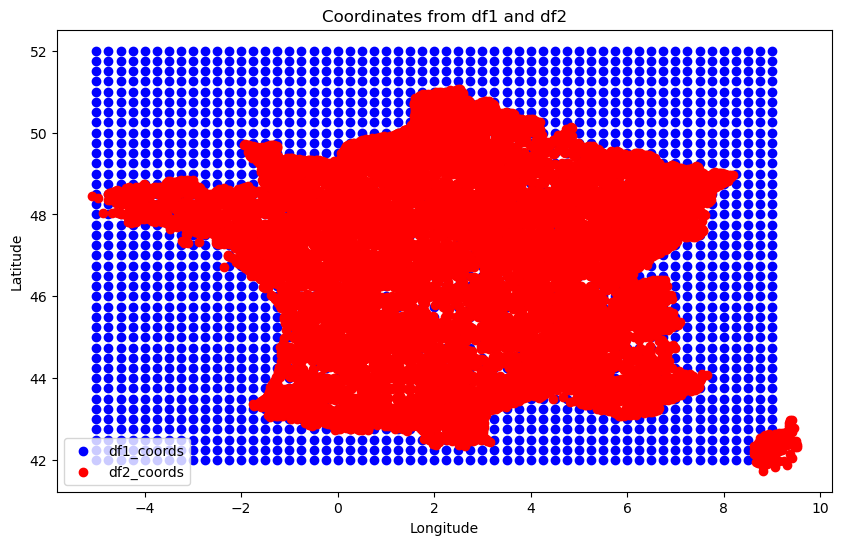

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the relevant columns into two separate DataFrames
df1_coords = df_far_sim_points[['latitude_1', 'longitude_1']].drop_duplicates().reset_index(drop=True)
df2_coords = df_far_sim_points[['latitude_2', 'longitude_2']].drop_duplicates().reset_index(drop=True)

# Plot the coordinates on the same map with different colors
plt.figure(figsize=(10, 6))

# Plot df1_coords in blue
plt.scatter(df1_coords['longitude_1'], df1_coords['latitude_1'], color='blue', label='df1_coords')

# Plot df2_coords in red
plt.scatter(df2_coords['longitude_2'], df2_coords['latitude_2'], color='red', label='df2_coords')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Coordinates from df1 and df2')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import folium
from ipywidgets import interact
from IPython.display import display

# Define the function to plot the map
def plot_interactive_map(distance_threshold):
    # Filter the DataFrame based on the input distance threshold
    df_far_sim_points_filtered = df_yearly_weather_decrees[df_yearly_weather_decrees['distance_km'] <= distance_threshold][['insee_2', 'latitude_1', 'longitude_1', 'latitude_2', 'longitude_2', 'distance_km']]
    
    # Extract the relevant coordinates
    df1_coords = df_far_sim_points_filtered[['latitude_1', 'longitude_1']].drop_duplicates().reset_index(drop=True)
    df2_coords = df_far_sim_points_filtered[['latitude_2', 'longitude_2']].drop_duplicates().reset_index(drop=True)

    # Set the initial location for the map to be the mean latitude and longitude from the filtered DataFrame
    mean_latitude = df1_coords['latitude_1'].mean() if not df1_coords.empty else 48.8566  # default to Paris if empty
    mean_longitude = df1_coords['longitude_1'].mean() if not df1_coords.empty else 2.3522  # default to Paris if empty

    # Create a Folium map centered on the mean coordinates
    m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=6)

    # Plot df1_coords in blue on the map
    for i, row in df1_coords.iterrows():
        folium.CircleMarker(
            location=[row['latitude_1'], row['longitude_1']],
            radius=5,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=f"df1_coords: ({row['latitude_1']}, {row['longitude_1']})"
        ).add_to(m)

    # Plot df2_coords in red on the map
    for i, row in df2_coords.iterrows():
        folium.CircleMarker(
            location=[row['latitude_2'], row['longitude_2']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"df2_coords: ({row['latitude_2']}, {row['longitude_2']})"
        ).add_to(m)

    # Display the map
    display(m)

# Create an interactive slider to adjust the distance threshold
interact(plot_interactive_map, distance_threshold=(0, 400, 5))


interactive(children=(IntSlider(value=200, description='distance_threshold', max=400, step=5), Output()), _dom…

<function __main__.plot_interactive_map(distance_threshold)>

In [ ]:
# so proud of myself ^^

In [ ]:
df_yearly_weather_decrees.isna().sum().sum()

2019150

### Recompute NAs Columns

### Note

In [ ]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Function to recompute columns ending with '_z_1' that have NA values
def recompute_columns_with_na(df):
    # Check for columns ending with '_z_1'
    z_1_cols = [col for col in df.columns if col.endswith('_z_1')]
    
    # Initialize RobustScaler
    scaler = RobustScaler()
    
    # Iterate through the identified columns
    for col in z_1_cols:
        # If the column has NA values
        if df[col].isna().any():
            # Find corresponding column without '_z_1'
            corresponding_col = col.replace('_z_1', '_1')
            
            # Check if the corresponding column exists
            if corresponding_col in df.columns:
                # Compute the new values using RobustScaler
                df[col] = scaler.fit_transform(df[[corresponding_col]])
            else:
                print(f"Corresponding column {corresponding_col} not found for {col}.")
    
    return df



# Apply the function
df_yearly_weather_decrees = recompute_columns_with_na(df_yearly_weather_decrees)

print(df_yearly_weather_decrees)


          date_1  latitude_1  longitude_1     u10_1     v10_1      t2m_1  \
0     1990-01-01        52.0        -5.00  4.854118  5.280374   8.799219   
1     1990-01-01        52.0        -4.75  4.120720  4.837014   8.308984   
2     1990-01-01        52.0        -4.50  2.978630  3.999124   7.713281   
3     1990-01-01        52.0        -4.25  2.781364  3.996194   7.287500   
4     1990-01-01        52.0        -4.00  2.592888  3.729104   6.516016   
...          ...         ...          ...       ...       ...        ...   
18691 2024-08-01        42.0         8.00  1.438617 -0.738438  26.516504   
18692 2024-08-01        42.0         8.25  1.178851 -0.563145  26.979395   
18693 2024-08-01        42.0         8.50  0.999652 -0.279453  26.137598   
18694 2024-08-01        42.0         8.75  0.703265 -0.061680  24.969629   
18695 2024-08-01        42.0         9.00  0.246722  0.062832  23.719629   

              sp_1      tp_1       e_1     sro_1  ...  Code Arrondissement_2  \
0      

In [ ]:
df_yearly_weather_decrees.isna().sum().sum()

0

In [ ]:
df_weather_decrees['year_2'].nunique()

35

### Note

>We will retain simupoints located within 25km of a commune’s geographical center.

### Save weather_decrees data

In [ ]:
max_distance_mesure_location_km = 25

In [ ]:
df_to_save = df_weather_decrees[df_weather_decrees['distance_km'] <= max_distance_mesure_location_km] # save to parquet

In [ ]:

df_to_save.to_parquet(os.path.join(processed_data_folder_name, weather_decrees_filename))
# Save the schema (data types) to a file
df_to_save.dtypes.to_csv(os.path.join(processed_data_folder_name, weather_decrees_shema))

## Test reloading

In [ ]:
# test reloading the dataframe from parquet
import pandas as pd

df_reloaded = pd.read_parquet(os.path.join(processed_data_folder_name, weather_decrees_filename))




In [ ]:
os.path.join(processed_data_folder_name, weather_decrees_shema)

'./../../data/processed/weather_decrees.csv'

In [ ]:
# Load the schema (data types) from the file
schema = pd.read_csv(os.path.join(processed_data_folder_name, weather_decrees_shema), index_col=0).squeeze("columns")

In [ ]:
# Apply the schema to the loaded dataframe
df_reloaded = df_reloaded.astype(schema.to_dict())

In [ ]:
df_reloaded.equals(df_to_save)

True

In [ ]:
# Check if dtypes are the same
assert df_reloaded.equals(df_to_save), "Data types do not match!"